# <center>  LAB10 - Równania różniczkowe - spectral bias </center>
# <center>  Gosztyła Mikołaj, Smółka Antoni </center> 

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

## Zadanie 1

Dane jest równanie różniczkowe zwyczajne

$$ \frac{du(x)}{dx} = \cos(\omega x) \quad \text{dla} \quad x \in \Omega, $$

gdzie:
- $ x, \omega, u \in \mathbb{R} $,
- $ x $ to położenie,
- $ \Omega $ to dziedzina, na której rozwiązujemy równanie, $ \Omega = \{ x \mid -2\pi \leq x \leq 2\pi \} $,
- $ u(\cdot) $ to funkcja, której postaci szukamy.

Warunek początkowy zdefiniowany jest następująco:

$$ u(0) = 0. $$

Analityczna postać rozwiązania równania z warunkiem początkowym jest następująca:

$$ u(x) = \frac{1}{\omega} \sin(\omega x). $$

Rozwiąż powyższe zagadnienie początkowe. Do rozwiązania użyj sieci neuronowych PINN (ang. Physics-informed Neural Network) [1]. Można wykorzystać szablon w pytorch-u lub bibliotekę DeepXDE [2].

Koszt rezydualny zdefiniowany jest następująco:

$$ L_r(\theta) = \frac{1}{N} \sum_{i=1}^{N} \left\| \frac{dû(x)}{dx} - \cos(\omega x_i) \right\|^2, $$

gdzie $ N $ jest liczbą punktów kolokacyjnych.

Koszt związany z warunkiem początkowym przyjmuje postać:

$$ L_{IC}(\theta) = \left\| û(0) - 0 \right\|^2. $$

Funkcja kosztu zdefiniowana jest następująco:

$$ L(\theta) = L_r(\theta) + L_{IC}(\theta). $$

Warstwa wejściowa sieci posiada 1 neuron, reprezentujący zmienną $ x $. Warstwa wyjściowa także posiada 1 neuron, reprezentujący zmienną $ û(x) $. Uczenie trwa przez 50 000 kroków algorytmem Adam ze stałą uczenia równą 0.001. Jako funkcję aktywacji przyjmij tangens hiperboliczny, $ \tanh $.



In [2]:
class FourierLayer(nn.Linear):
    def __init__(self, N_INPUT, N_HIDDEN):
        super().__init__( N_INPUT, N_HIDDEN)
        self.N_INPUT = N_INPUT
        self.N_HIDDEN = N_HIDDEN
        self.weight = torch.nn.Parameter(self._initialize_weights())

    def _initialize_weights(self):
        weights = np.zeros((self.N_HIDDEN, self.N_INPUT))
        for i in range(self.N_HIDDEN):
            for j in range(self.N_INPUT):
                if j % 2 == 0:
                    weights[i, j] = np.sin(2 ** (j+i) * np.pi)
                else:
                    weights[i, j] = np.cos(2 ** (j+i) * np.pi)
        weights = torch.tensor(weights, dtype=torch.float32)
        return weights

def exact_solution(x, omega):
    return np.sin(omega * x) / omega

class Network(nn.Module):
    def __init__(self, hidden_layers, hidden_layer_neurons, fourier=False):
        super(Network, self).__init__()
        activation = nn.Tanh
        self.start_layer = nn.Sequential(*[
            nn.Linear(1,hidden_layer_neurons),
            activation()
        ])
        self.hidden_layers = nn.Sequential(
                                *[nn.Sequential(*[nn.Linear(hidden_layer_neurons, hidden_layer_neurons), activation()]) 
            for i in range(hidden_layers)
        ])
        self.hidden_layers = nn.Sequential(
            *[nn.Sequential(*[
                nn.Linear(hidden_layer_neurons, hidden_layer_neurons), activation()
                ]) 
                if not fourier or i == 0 else nn.Sequential(*[FourierLayer(hidden_layer_neurons, hidden_layer_neurons), activation()])for i in range(hidden_layers)
        ])
        self.exit_layer = nn.Linear(hidden_layer_neurons, 1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.start_layer(x)
        x = self.hidden_layers(x)
        x = self.exit_layer(x)
        return x

def residual_loss(model: Network, x: torch.Tensor, omega: float):
    x = x.requires_grad_(True)
    u = model(x)
    u_x = torch.autograd.grad(u,x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    residual = u_x - torch.cos(omega * x)
    return torch.mean(residual**2)

def ansatz_residual_loss(model: Network, x: torch.Tensor, omega: float):
    x = x.requires_grad_(True)
    u = torch.tanh(omega * x) * model(x)
    u_x = torch.autograd.grad(u,x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    residual = u_x - torch.cos(omega * x)
    return torch.mean(residual**2)

def initial_loss(model: nn.Module):
    u_0 = model(torch.tensor([[0.0]], dtype=torch.float32))
    return torch.mean(u_0**2)

def total_loss(model: nn.Module, x, omega):
    return residual_loss(model=model, x=x, omega=omega) + initial_loss(model=model)

In [3]:
def learn(omega, t_points, hidden_layers, neurons, loss_fun, lr=0.001, epochs=50000, fourier=False) -> Network:
    domain = np.linspace(-2 * np.pi, 2 * np.pi, t_points).reshape(-1, 1)
    model = Network(hidden_layers=hidden_layers, hidden_layer_neurons=neurons, fourier=fourier)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    x_tensor = torch.tensor(domain, dtype=torch.float32)
    loss_buff = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fun(model, x_tensor, omega)
        loss_buff.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
        
    plt.plot(loss_buff)
    plt.xlabel("Epoch")
    plt.ylabel("Loss Function")
    plt.title("Funkcja kosztu")
    plt.grid()
    plt.show()

    return model


In [4]:
def predict(model: nn.Module, domain):
    x_tensor = torch.tensor(domain, dtype=torch.float32)
    return model(x_tensor).detach().numpy()

In [28]:
u_true_A = exact_solution(x=test_domain_A, omega=1)
u_true_B = exact_solution(x=test_domain_B, omega=15)

In [5]:
test_points_A = 1000

test_domain_A = np.linspace(-2*np.pi, 2*np.pi, test_points_A).reshape(-1,1)

u_true = exact_solution(x=test_domain_A, omega=1)

### (a) Przypadek $ \omega = 1 $

Ustal następujące wartości:
- 2 warstwy ukryte, 16 neuronów w każdej warstwie,
- liczba punktów treningowych: 200,
- liczba punktów testowych: 1000.

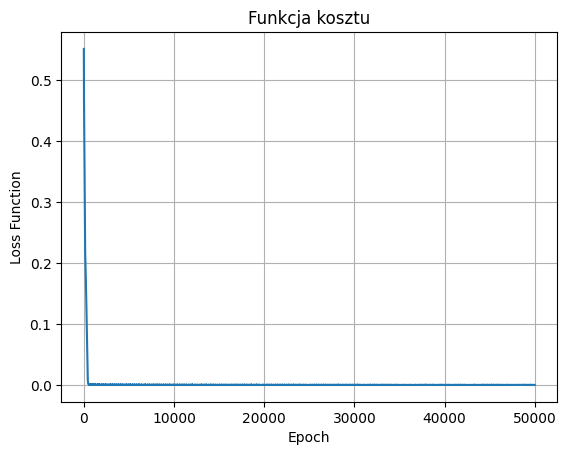

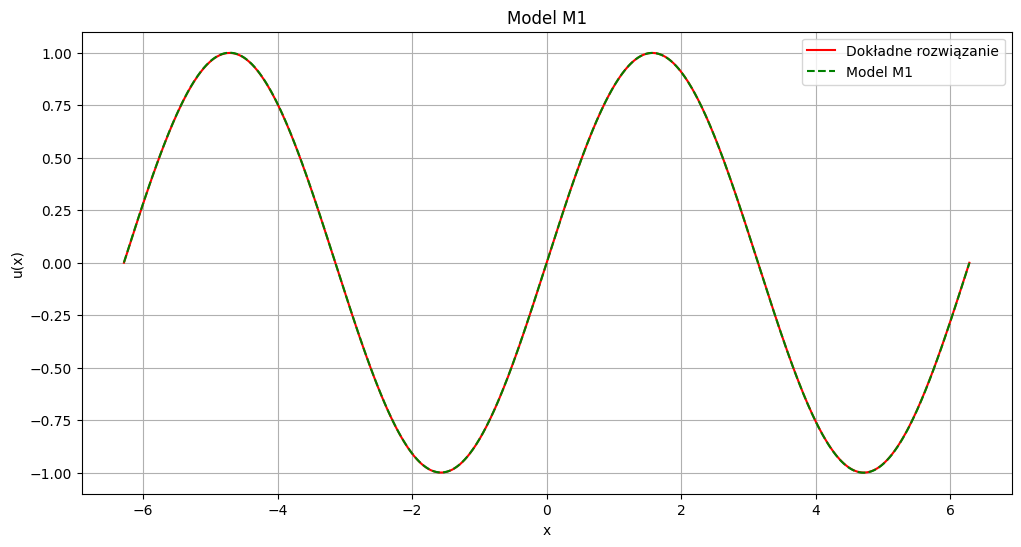

In [6]:
m1 = learn(omega=1, t_points=200,hidden_layers=2,neurons=16, loss_fun=total_loss)
m1_pred = predict(model=m1, domain=test_domain_A)
plt.figure(figsize=(12, 6))
plt.plot(test_domain_A, u_true, label="Dokładne rozwiązanie", color="red")
plt.plot(test_domain_A, m1_pred, label="Model M1", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M1")
plt.show()

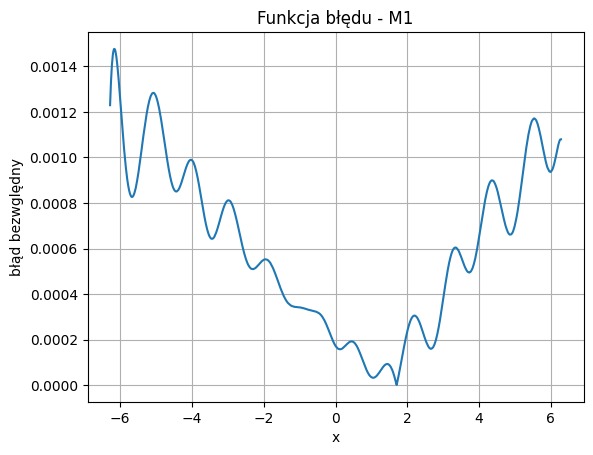

In [41]:
plt.plot(test_domain_A, np.abs(m1_pred - u_true_A))
plt.xlabel("x")
plt.ylabel("błąd bezwględny")
plt.title("Funkcja błędu - M1")
plt.grid()
plt.show()

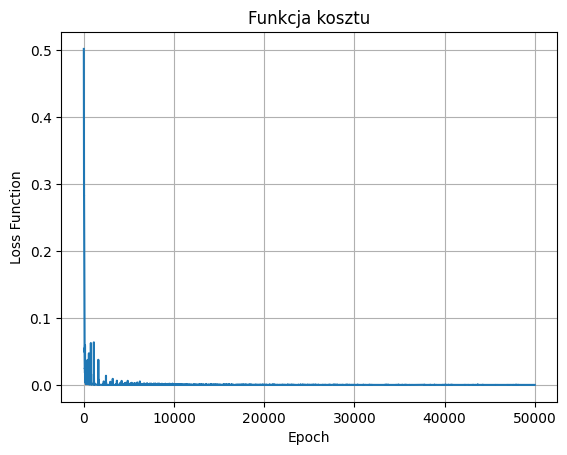

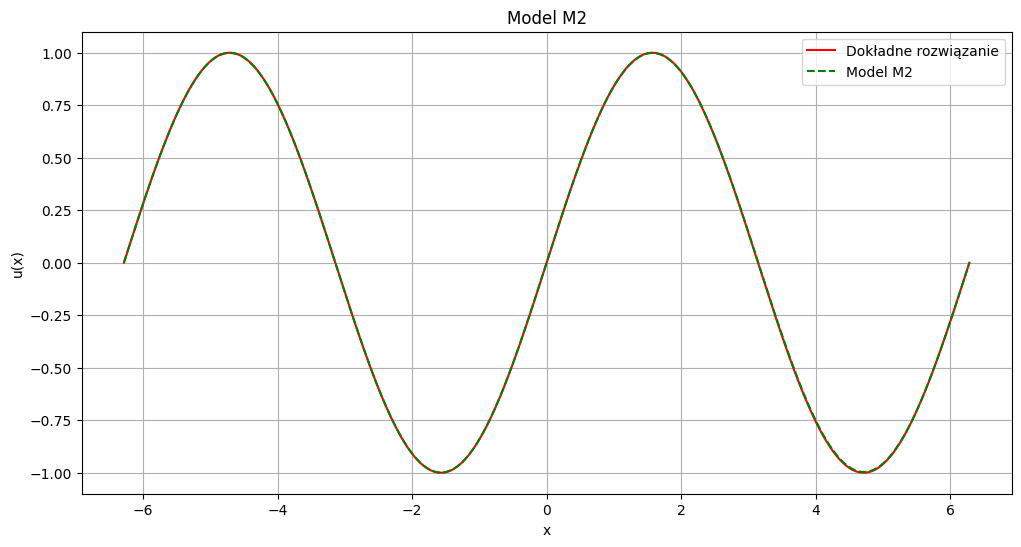

In [7]:
m2 = learn(omega=1, t_points=200, hidden_layers=4, neurons=64, loss_fun=total_loss)
m2_pred = predict(model=m2, domain=test_domain_A)
plt.figure(figsize=(12, 6))
plt.plot(test_domain_A, u_true, label="Dokładne rozwiązanie", color="red")
plt.plot(test_domain_A, m2_pred, label="Model M2", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M2")
plt.show()

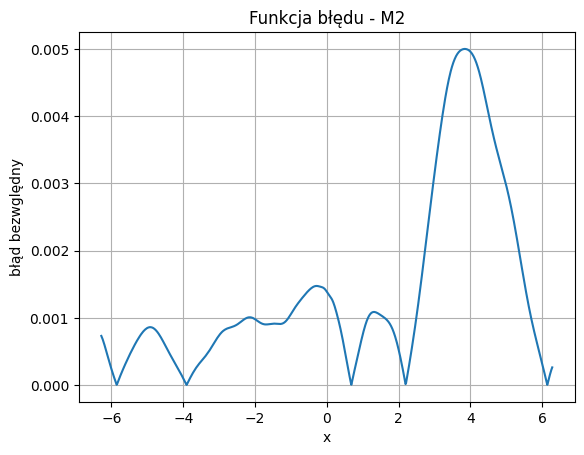

In [43]:
plt.plot(test_domain_A, np.abs(m2_pred - u_true_A))
plt.xlabel("x")
plt.ylabel("błąd bezwględny")
plt.title("Funkcja błędu - M2")
plt.grid()
plt.show()

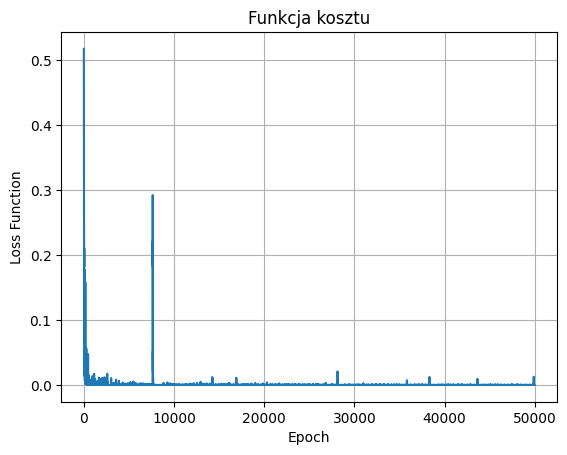

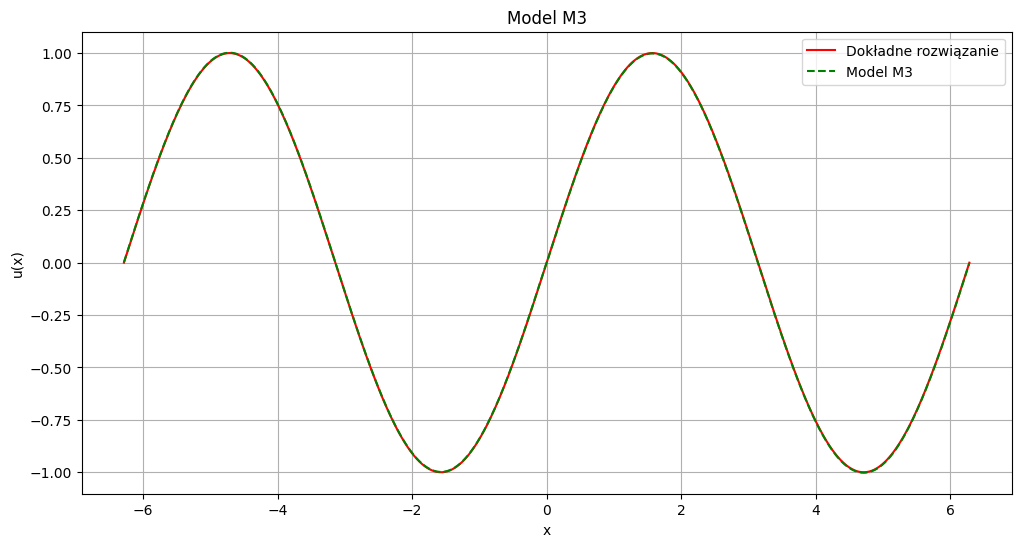

In [8]:
m3 = learn(omega=1, t_points=200, hidden_layers=5, neurons=128, loss_fun=total_loss)
m3_pred = predict(model=m3, domain=test_domain_A)
plt.figure(figsize=(12, 6))
plt.plot(test_domain_A, u_true, label="Dokładne rozwiązanie", color="red")
plt.plot(test_domain_A, m3_pred, label="Model M3", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M3")
plt.show()

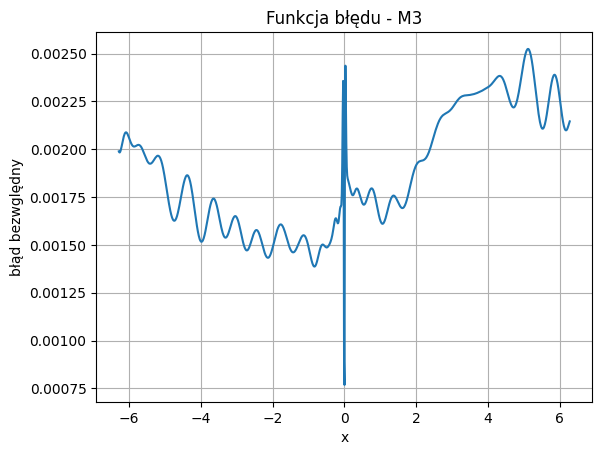

In [44]:
plt.plot(test_domain_A, np.abs(m3_pred - u_true_A))
plt.xlabel("x")
plt.ylabel("błąd bezwględny")
plt.title("Funkcja błędu - M3")
plt.grid()
plt.show()

### (b) Przypadek $ \omega = 15 $

Ustal następujące wartości:
- liczba punktów treningowych: $ 200 \cdot 15 = 3000 $,
- liczba punktów testowych: 5000.

Eksperymenty przeprowadź z trzema architekturami sieci:
- 2 warstwy ukryte, 16 neuronów w każdej warstwie,
- 4 warstwy ukryte, 64 neurony w każdej warstwie,
- 5 warstw ukrytych, 128 neuronów w każdej warstwie.

In [9]:
test_points_B = 5000

test_domain_B = np.linspace(-2*np.pi, 2*np.pi, test_points_B).reshape(-1,1)

u_true = exact_solution(x=test_domain_B, omega=15)

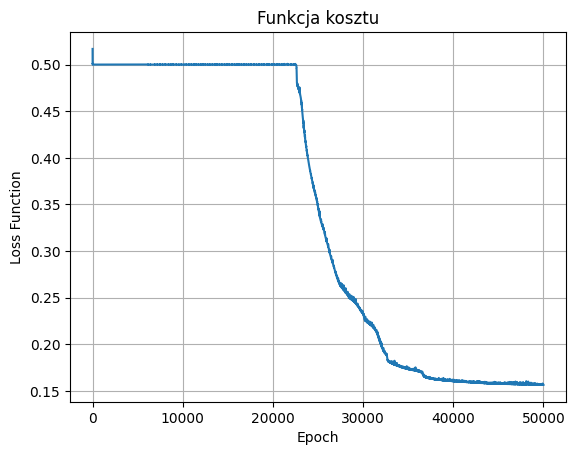

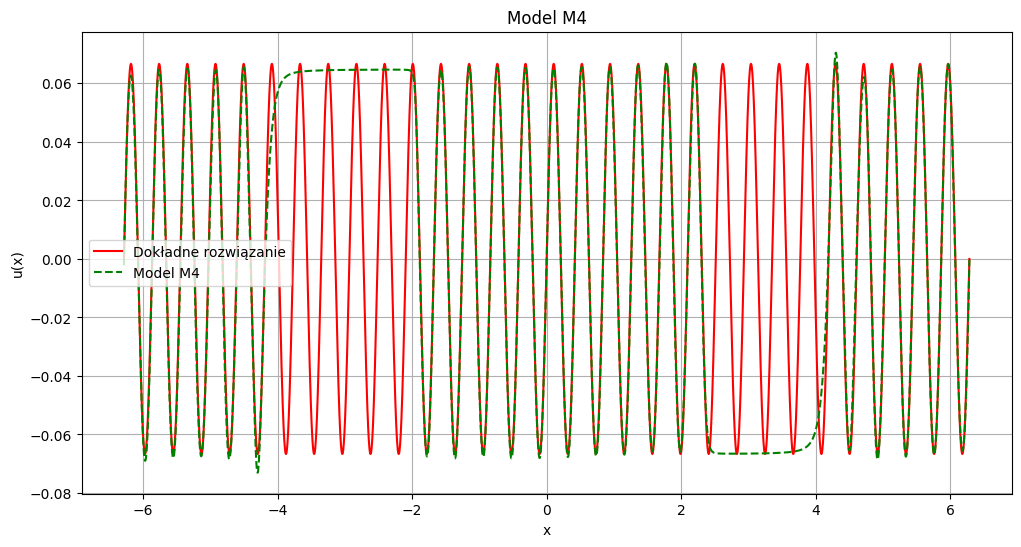

In [10]:
m4 = learn(omega=15,t_points=3000, hidden_layers=2, neurons=16, loss_fun=total_loss)
m4_pred = predict(m4, test_domain_B)
plt.figure(figsize=(12, 6))
plt.plot(test_domain_B, u_true, label="Dokładne rozwiązanie", color="red")
plt.plot(test_domain_B, m4_pred, label="Model M4", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M4")
plt.show()

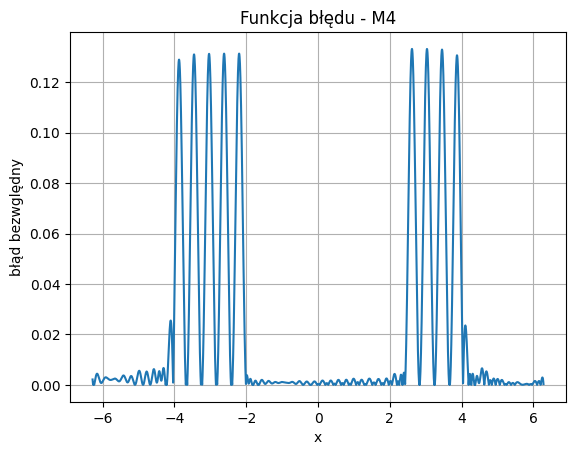

In [45]:
plt.plot(test_domain_B, np.abs(m4_pred - u_true_B))
plt.xlabel("x")
plt.ylabel("błąd bezwględny")
plt.title("Funkcja błędu - M4")
plt.grid()
plt.show()

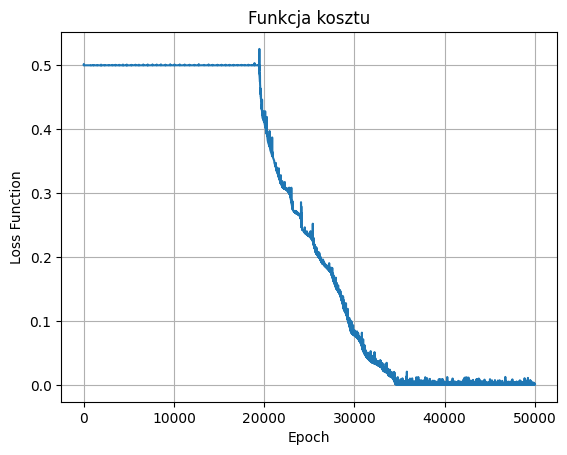

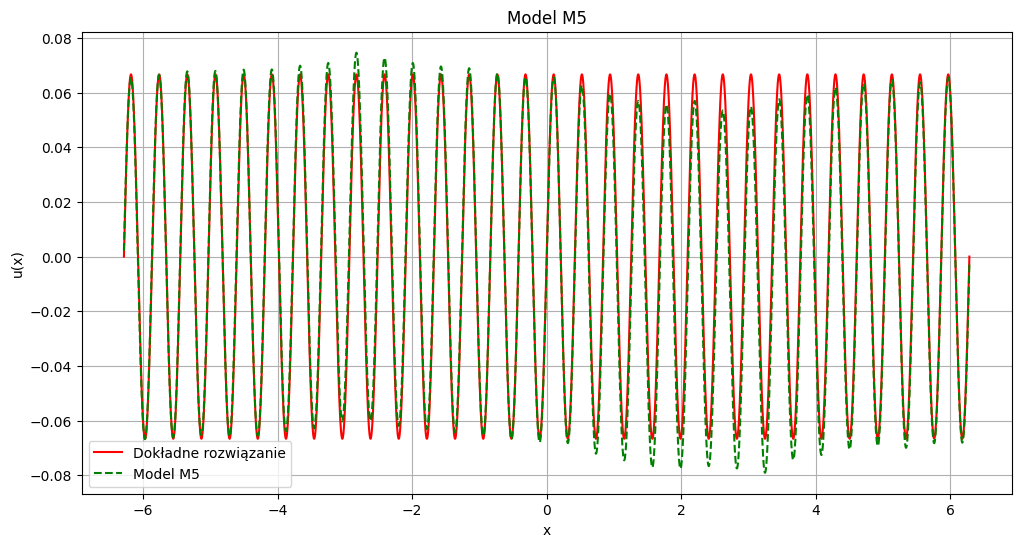

In [11]:
m5 = learn(omega=15,t_points=3000, hidden_layers=4, neurons=64, loss_fun=total_loss)
m5_pred = predict(m5, test_domain_B)
plt.figure(figsize=(12, 6))
plt.plot(test_domain_B, u_true, label="Dokładne rozwiązanie", color="red")
plt.plot(test_domain_B, m5_pred, label="Model M5", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M5")
plt.show()

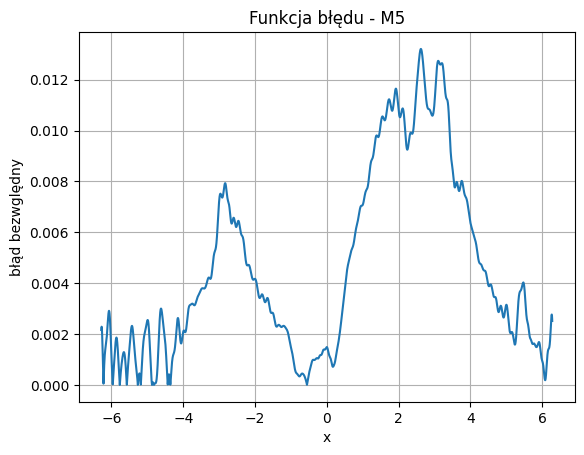

In [46]:
plt.plot(test_domain_B, np.abs(m5_pred - u_true_B))
plt.xlabel("x")
plt.ylabel("błąd bezwględny")
plt.title("Funkcja błędu - M5")
plt.grid()
plt.show()

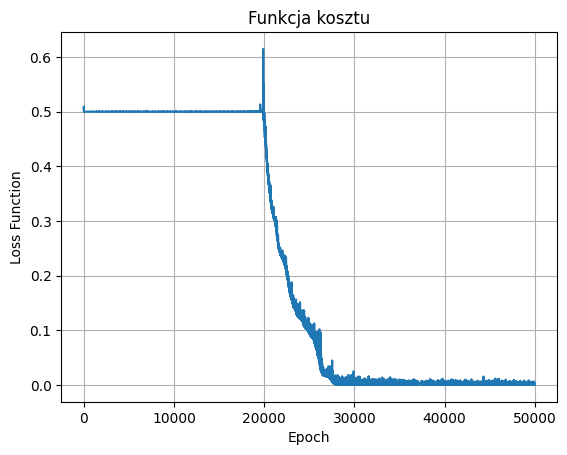

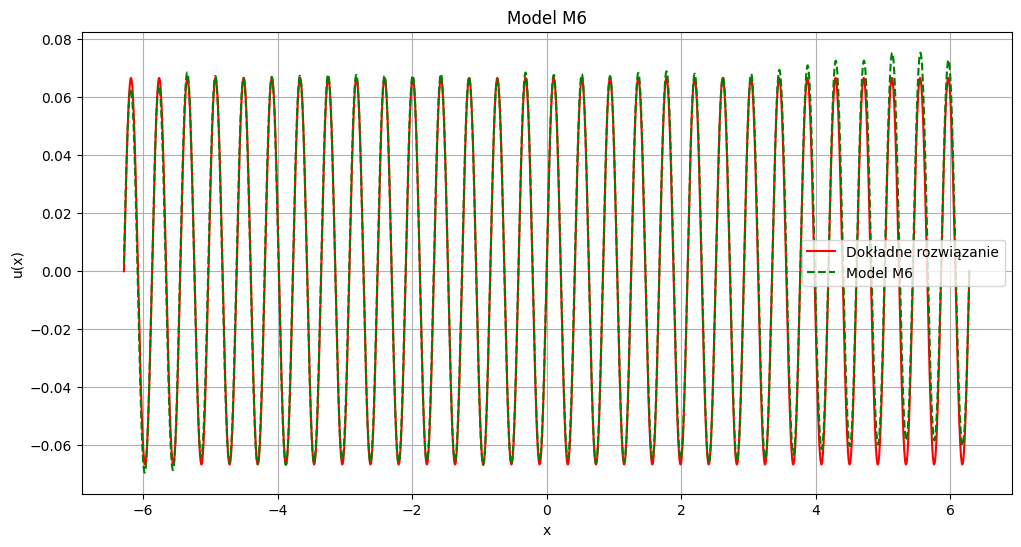

In [12]:
m6 = learn(omega=15, t_points=3000, hidden_layers=5,neurons=128, loss_fun=total_loss)
m6_pred = predict(m6, test_domain_B)
plt.figure(figsize=(12, 6))
plt.plot(test_domain_B, u_true, label="Dokładne rozwiązanie", color="red")
plt.plot(test_domain_B, m6_pred, label="Model M6", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M6")
plt.show()

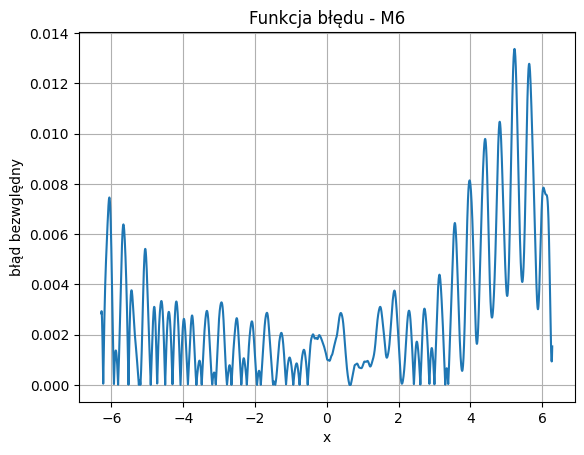

In [47]:
plt.plot(test_domain_B, np.abs(m6_pred - u_true_B))
plt.xlabel("x")
plt.ylabel("błąd bezwględny")
plt.title("Funkcja błędu - M6")
plt.grid()
plt.show()

### (c) Dla wybranej przez siebie sieci porównaj wynik z rozwiązaniem, w którym przyjęto, że szukane rozwiązanie (ansatz) ma postać:

$$ û(x; \theta) = \tanh(\omega x) \cdot NN(x; \theta). $$

Taka postać rozwiązania gwarantuje spełnienie warunku $ û(0) = 0 $ bez wprowadzania składnika $ L_{IC} $ do funkcji kosztu.



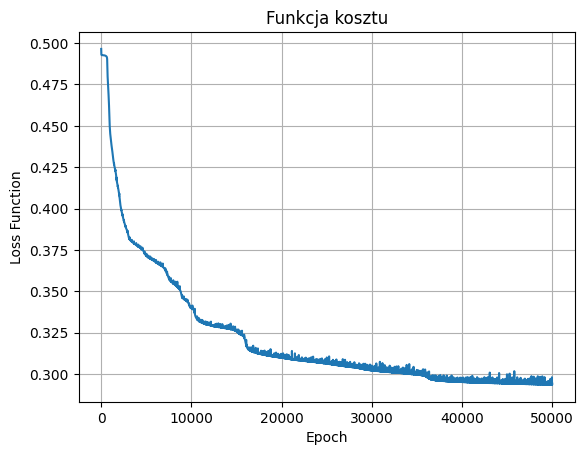

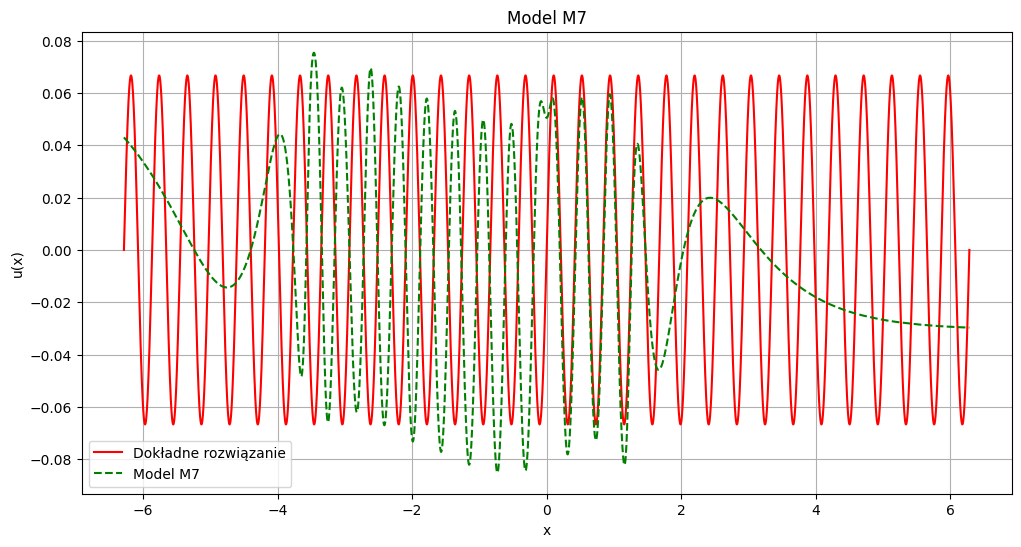

In [13]:
m7 = learn(omega=15,t_points=3000, hidden_layers=2, neurons=16, loss_fun=ansatz_residual_loss)
m7_pred = predict(m7, test_domain_B)
plt.figure(figsize=(12, 6))
plt.plot(test_domain_B, u_true, label="Dokładne rozwiązanie", color="red")
plt.plot(test_domain_B, m7_pred, label="Model M7", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M7")
plt.show()

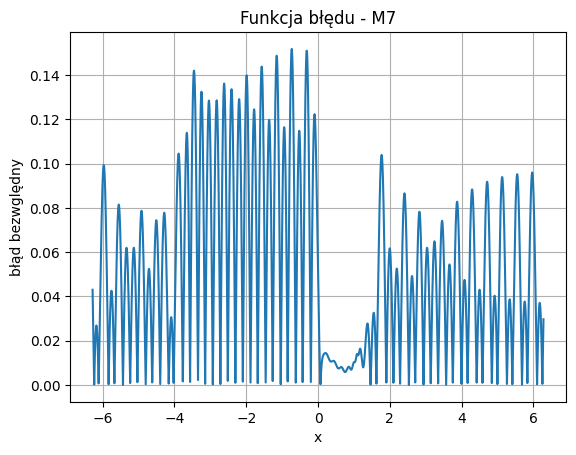

In [48]:
plt.plot(test_domain_B, np.abs(m7_pred - u_true_B))
plt.xlabel("x")
plt.ylabel("błąd bezwględny")
plt.title("Funkcja błędu - M7")
plt.grid()
plt.show()

### (d) Porównaj pierwotny wynik z rozwiązaniem, w którym pierwszą warstwę ukrytą zainicjalizowano cechami Fouriera:

$$ \gamma(x) = [ \sin(20\pi x), \cos(20\pi x), \ldots, \sin(2L-1\pi x), \cos(2L-1\pi x) ]. $$

Dobierz $ L $ tak, aby nie zmieniać szerokości warstwy ukrytej.

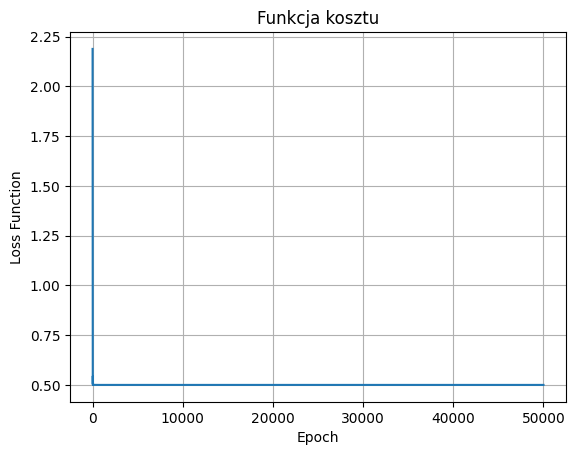

In [14]:
m8 = learn(omega=15,t_points=3000, hidden_layers=2, neurons=16, loss_fun=total_loss, fourier=True)

In [15]:
m8_pred = predict(m8, test_domain_B)

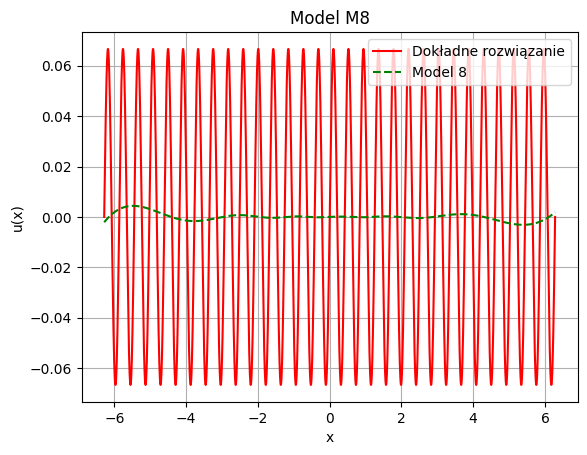

In [18]:
plt.plot(test_domain_B, u_true, label="Dokładne rozwiązanie", color="red")
plt.plot(test_domain_B, m8_pred, label="Model 8", linestyle="dashed", color="green")
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Model M8")
plt.show()

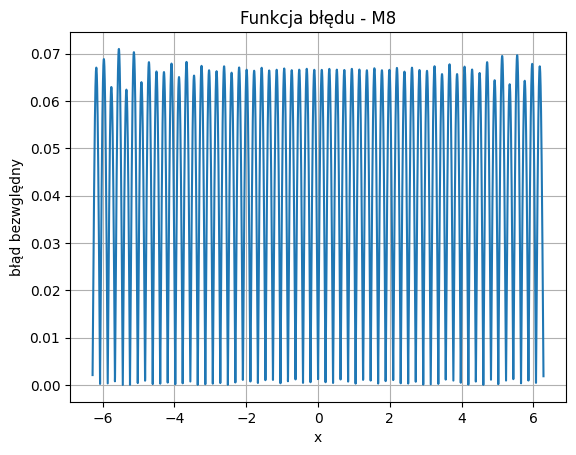

In [49]:
plt.plot(test_domain_B, np.abs(m8_pred - u_true_B))
plt.xlabel("x")
plt.ylabel("błąd bezwględny")
plt.title("Funkcja błędu - M8")
plt.grid()
plt.show()

## Wnioski


Z przeprowadzonych eksperymentów wynika, że zwiększenie liczby neuronów w sieci neuronowej przyczynia się do poprawy dokładności uzyskiwanych wyników. W szczególności:

- **Dla ω = 1:** Przy relatywnie niskiej wartości ω, sieć z 2 warstwami ukrytymi i 16 neuronami w każdej warstwie była w stanie osiągnąć zadowalającą dokładność. To sugeruje, że dla mniej skomplikowanych funkcji, mniejsze sieci mogą być wystarczające.
- **Dla ω = 15:** Przy wyższej częstotliwości ω, dokładność rozwiązania znacznie wzrosła wraz ze zwiększeniem liczby neuronów i warstw. Sieć z 5 warstwami ukrytymi i 128 neuronami w każdej warstwie zapewniła najlepsze wyniki. Sugeruje to, że dla bardziej złożonych problemów zwiększenie liczby neuronów i głębokości sieci jest konieczne do osiągnięcia wysokiej dokła

Z przeprowadzonych eksperymentów wynika, że zwiększenie liczby neuronów i głębokości sieci neuronowej znacząco poprawia dokładność uzyskiwanych wyników w rozwiązywaniu równań różniczkowych za pomocą sieci neuronowych PINN. Dla bardziej złożonych problemów, takich jak przypadek z wysoką częstotliwością ω = 15, konieczne jest stosowanie bardziej rozbudowanych architektur sieci. Dodatkowo, wprowadzenie alternatywnych podejść, takich jak ansatz z funkcją aktywacji czy inicjalizacja cechami Fouriera, może znacząco wpłynąć na jakość i szybkość uzyskiwanych rozwiązań.ość uzyskiwanych rozwiązań.